In [1]:
from PIL import Image, ImageChops, ImageFilter
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from cv2 import cv2
import os
from torch.utils.data import DataLoader
%matplotlib inline

In [2]:
from nets import FSDNet, basic, basic_DSC
import torch
from torch import nn
from torch import optim
import os
import numpy as np

In [3]:
args = {
    'iter_num': 50000,
    'train_batch_size': 6,
    'last_iter': 0,
    'lr': 0.005,
    'lr_decay': 0.9,
    'weight_decay': 5e-4,

    'momentum': 0.9,
    'nesterov': False,
    'resume_snapshot': '',
    'val_freq': 10000,
    'img_size_h': 512,
    'img_size_w': 512,
    'crop_size': 512,
    'snapshot_epochs': 10000,
    'backbone': 'mobilenet', # 'resnet', 'xception', 'drn', 'mobilenet'],
    'out_stride': 16, # 8 or 16
    'sync_bn': None, # whether to use sync bn (default: auto)
    'freeze_bn': False,
    'pre_train': True

}

In [4]:
net = FSDNet(num_classes=1, 
             backbone=args['backbone'], 
             output_stride=args['out_stride'], 
             sync_bn=args['sync_bn'], 
             freeze_bn=args['freeze_bn'])
net.cuda()
net.load_state_dict(torch.load(os.path.join('./ckpt', 'FSDNetvisha', '50000.pth'),
                                       map_location=lambda storage, loc: storage.cuda(0)))
net.eval()

FSDNet(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
          (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [5]:
path_im1 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/images/roadblock/00000051.jpg'
path_im2 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/images/roadblock/00000052.jpg'

In [6]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])
img1 = Image.open(path_im1).convert('RGB')
img2 = Image.open(path_im2).convert('RGB')
img1 = transform(img1)
img2 = transform(img2)
img1 = img1.unsqueeze(0).cuda()
img2 = img2.unsqueeze(0).cuda()

In [7]:
low_level_feat1 = net.backbone.low_level_features(img1)
low_level_feat2 = net.backbone.low_level_features(img2)

middle_level_feat1 = net.backbone.middle_level_features(low_level_feat1)
middle_level_feat2 = net.backbone.middle_level_features(low_level_feat2)

high_level_feat1 = net.backbone.high_level_features(middle_level_feat1)
high_level_feat2 = net.backbone.high_level_features(middle_level_feat2)

x1 = net.reduce1(high_level_feat1)
dsc1 = net.dsc(x1)
x1 = net.reduce2(torch.cat((high_level_feat1, dsc1), 1))

x1 = net.decoder(dsc1, low_level_feat1, middle_level_feat1, x1) # 256,256,256,256
x1 = F.interpolate(x1, size=img1.size()[2:], mode='bilinear', align_corners=True)       
x1 = torch.sigmoid(x1)

x2 = net.reduce1(high_level_feat2)
dsc2 = net.dsc(x2)
x2 = net.reduce2(torch.cat((high_level_feat2, dsc2), 1))

x2 = net.decoder(dsc2, low_level_feat2, middle_level_feat2, x2) # 256,256,256,256
x2 = F.interpolate(x2, size=img2.size()[2:], mode='bilinear', align_corners=True)       
x2 = torch.sigmoid(x2)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

In [8]:
p1 = x1.detach().cpu().squeeze(0).numpy()
p2 = x2.detach().cpu().squeeze(0).numpy()

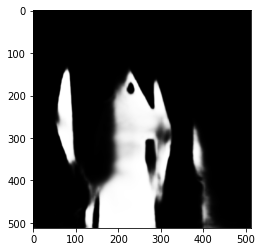

In [21]:
imshow(p1[0], 'gray')

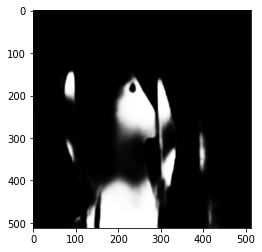

In [22]:
imshow(p2[0], 'gray')

In [23]:
feat1 = low_level_feat1.detach().cpu().squeeze(0).numpy()
feat2 = low_level_feat2.detach().cpu().squeeze(0).numpy()

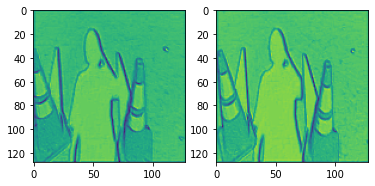

In [32]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(feat1[8])
axarr[1].imshow(feat2[8])

In [1]:
from dataset import ImageFolder, ViShaFolder
from torchvision import transforms
import joint_transforms
from torch.utils.data import DataLoader
import os
from PIL import Image

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

to_pil = transforms.ToPILImage()

joint_transform = joint_transforms.Compose([
    joint_transforms.Resize((512, 512)),
    joint_transforms.RandomHorizontallyFlip()
])

joint_transform_val = joint_transforms.Compose([
    joint_transforms.Resize((512, 512)),
])

visha_path = '/nfs/bigcornea/add_disk0/shilinhu/ViSha'
train_set = ViShaFolder(visha_path, transform=transform, target_transform=transform, joint_transform=joint_transform, is_train=True, batch_size=6)
train_loader = DataLoader(train_set, batch_size=6, num_workers=8, shuffle=True)

test1_set = ViShaFolder(visha_path, transform=transform, target_transform=transform, joint_transform=joint_transform_val, is_train=False, batch_size=6)
test1_loader = DataLoader(test1_set, batch_size=6, num_workers=8)

In [4]:
next(iter(train_loader))

/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/run_dog/00000074.jpg torch.Size([3, 512, 512])
/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/labels/run_dog/00000074.png torch.Size([1, 512, 512])
/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/crossing/00000087.jpg torch.Size([3, 512, 512])
/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/labels/crossing/00000087.png /nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/jump3/00000061.jpgtorch.Size([1, 512, 512]) 
torch.Size([3, 512, 512])
/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/labels/jump3/00000061.png torch.Size([1, 512, 512])
/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/skateboard-13/00000059.jpg torch.Size([3, 512, 512])
/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/labels/skateboard-13/00000059.png torch.Size([1, 512, 512])
/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/billiard_2/00000016.jpg /nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/yoyo-18/00000002.jpgtorch.Size([3, 512, 512]) 
torch.Size([3

[tensor([[[[0.4510, 0.4510, 0.4510,  ..., 0.8745, 0.8745, 0.8745],
           [0.4510, 0.4510, 0.4510,  ..., 0.8745, 0.8745, 0.8745],
           [0.4549, 0.4588, 0.4588,  ..., 0.8784, 0.8784, 0.8784],
           ...,
           [0.2431, 0.2431, 0.2431,  ..., 0.6353, 0.6353, 0.6353],
           [0.2431, 0.2431, 0.2431,  ..., 0.6392, 0.6392, 0.6392],
           [0.2431, 0.2431, 0.2431,  ..., 0.6431, 0.6431, 0.6431]],
 
          [[0.3882, 0.3882, 0.3882,  ..., 0.7216, 0.7216, 0.7216],
           [0.3882, 0.3882, 0.3882,  ..., 0.7216, 0.7216, 0.7216],
           [0.3882, 0.3882, 0.3882,  ..., 0.7255, 0.7255, 0.7255],
           ...,
           [0.2549, 0.2549, 0.2549,  ..., 0.5569, 0.5569, 0.5569],
           [0.2549, 0.2549, 0.2549,  ..., 0.5608, 0.5608, 0.5608],
           [0.2549, 0.2549, 0.2549,  ..., 0.5647, 0.5647, 0.5647]],
 
          [[0.3882, 0.3882, 0.3882,  ..., 0.6627, 0.6627, 0.6627],
           [0.3882, 0.3882, 0.3882,  ..., 0.6627, 0.6627, 0.6627],
           [0.3922, 0.39

In [15]:
root = '/nfs/bigcornea/add_disk0/shilinhu/ViSha'
video_root = os.path.join(root, 'train')
video_list = [video for video in os.listdir(os.path.join(video_root, 'images')) if os.path.isdir(os.path.join(video_root, 'images', video))]
img_name = []
for v in video_list:
    for img in os.listdir(os.path.join(video_root, 'images', v)):
        if img.endswith('.jpg'):
            img_name.append([os.path.join(video_root, 'images', v, img), os.path.join(video_root, 'labels', v, img[:-4]+'.png')])

In [19]:
img_path, gt_path = img_name[0]

In [25]:
img = Image.open(img_path).convert('RGB')
target = Image.open(gt_path)

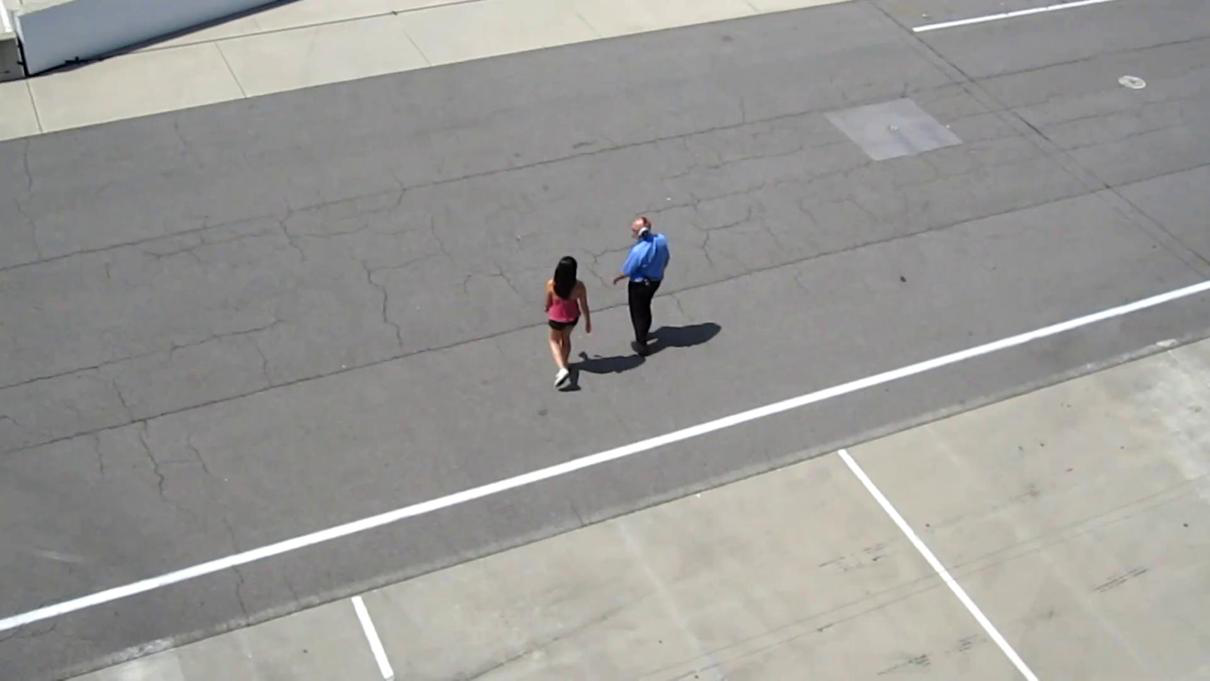

In [27]:
img

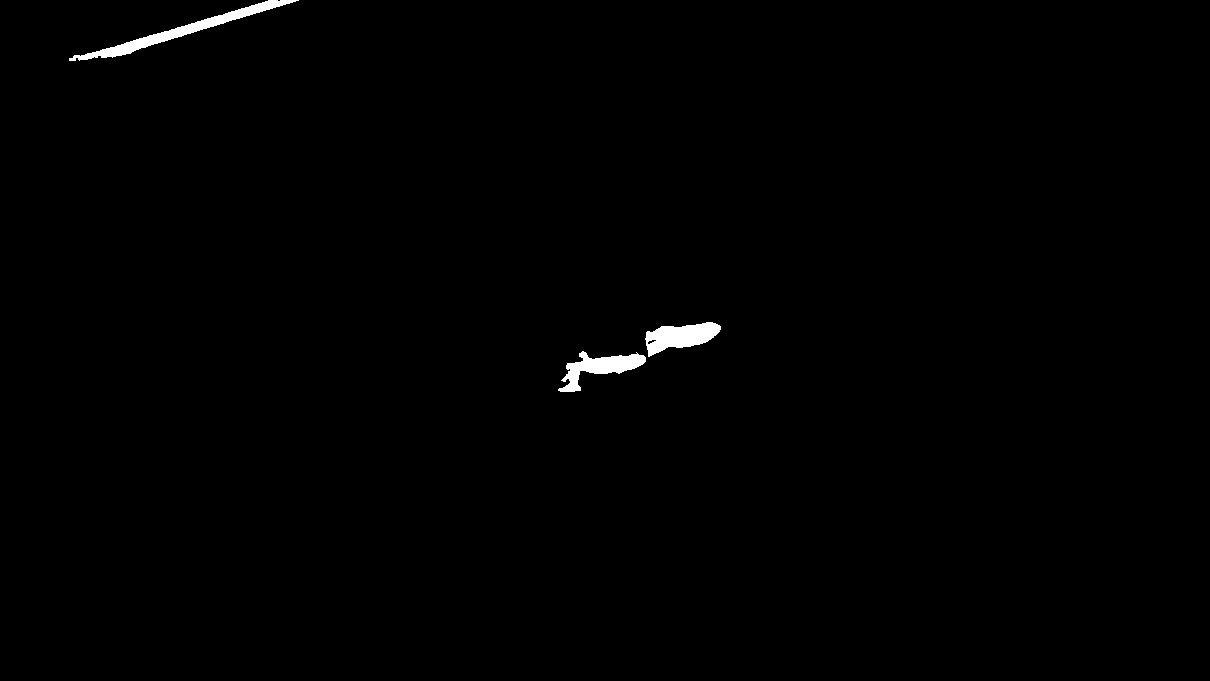

In [28]:
target